# Prediction of Stock Prices with Neural Networks

In [83]:
# Dependencies 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web 
import datetime as dt 
import plotly.graph_objs as go
import seaborn as sns
plt.style.use('ggplot')


# Machine Learning/Neural Networks
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Data
import yfinance as yf

## Data

In the LSE_STOCKS file we had determined that the stock with the highest Pct Change over the last year was SHELL stock, so we will be using this example for the prediction. 

In [84]:
company = 'SHEL.L'

In [85]:
# Define the time period
start = dt.datetime(2015,1,1)
end = dt.datetime(2023,1,1)


In [86]:
# Retrieve the historical data for the stocks
df = yf.download(company, start=start, end=end)
df = df.fillna(method='ffill')
df = df.drop(index=df[df["Low"] < 1000].index)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-22,2372.0,2398.5,2348.22998,2352.5,2330.507568,11705479
2022-12-23,2354.5,2366.5,2343.50000,2366.5,2344.376709,5855471
2022-12-28,2390.5,2395.5,2340.00000,2350.0,2328.030762,7447764
2022-12-29,2331.0,2357.0,2321.50000,2349.5,2327.535645,7601569
2022-12-30,2345.0,2346.5,2326.00000,2326.0,2304.255127,6999954


### Visualization of the SHELL Stock

In [87]:
# Create a candlestick chart
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df['Open'],
                                     high=df['High'],
                                     low=df['Low'],
                                     close=df['Close'])])

# Set the chart title and axis labels
fig.update_layout(title=company + ' Stock Price',
                  yaxis_title='Price (GBP)',
                  xaxis_title='Date')

# Display the chart
fig.show()

### Preparing the data

In [88]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [89]:
prediction_days = 60

In [90]:
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

## Building the model

In [91]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next closing price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train,y_train,epochs=25,batch_size=32)

Epoch 1/25
61/61 [==============================] - 9s 44ms/step - loss: 0.0995
Epoch 2/25
61/61 [==============================] - 2s 38ms/step - loss: 0.0691
Epoch 3/25
61/61 [==============================] - 2s 38ms/step - loss: 0.0643
Epoch 4/25
61/61 [==============================] - 2s 38ms/step - loss: 0.0630
Epoch 5/25
61/61 [==============================] - 2s 39ms/step - loss: 0.0620
Epoch 6/25
61/61 [==============================] - 2s 38ms/step - loss: 0.0616
Epoch 7/25
61/61 [==============================] - 2s 38ms/step - loss: 0.0601
Epoch 8/25
61/61 [==============================] - 2s 38ms/step - loss: 0.0595
Epoch 9/25
61/61 [==============================] - 2s 39ms/step - loss: 0.0590
Epoch 10/25
61/61 [==============================] - 2s 38ms/step - loss: 0.0593
Epoch 11/25
61/61 [==============================] - 2s 38ms/step - loss: 0.0585
Epoch 12/25
61/61 [==============================] - 2s 40ms/step - loss: 0.0586
Epoch 13/25
61/61 [==================

### Testing the model accuracy on the existing data

In [92]:
# Load the Test Data
test_start = dt.datetime(2023,1,1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)
test_data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-13,2531.5,2539.280029,2398.000000,2438.0,2438.0,19306371
2023-03-14,2422.5,2483.000000,2395.189941,2469.5,2469.5,19015334
2023-03-15,2459.0,2459.000000,2258.500000,2259.5,2259.5,48427247
2023-03-16,2300.0,2304.500000,2163.000000,2209.0,2209.0,26462458
2023-03-17,2247.0,2300.000000,2195.000000,2214.0,2214.0,37482036


In [93]:
actual_prices = test_data['Close'].values

total_dataset = pd.concat((df['Close'],test_data['Close']),axis=0)

In [100]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [106]:
# Make Predictions on the Test Data
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = np.reshape(predicted_prices, (predicted_prices.shape[0], 1))
predicted_prices = scaler.inverse_transform(predicted_prices)

2/2 [==============================] - 0s 14ms/step


ValueError: cannot reshape array of size 3240 into shape (54,1)

In [104]:
x_test.shape

(54, 60, 1)

In [105]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)   

2/2 [==============================] - 0s 16ms/step


ValueError: Found array with dim 3. None expected <= 2.

### Plotting the Test Predictions

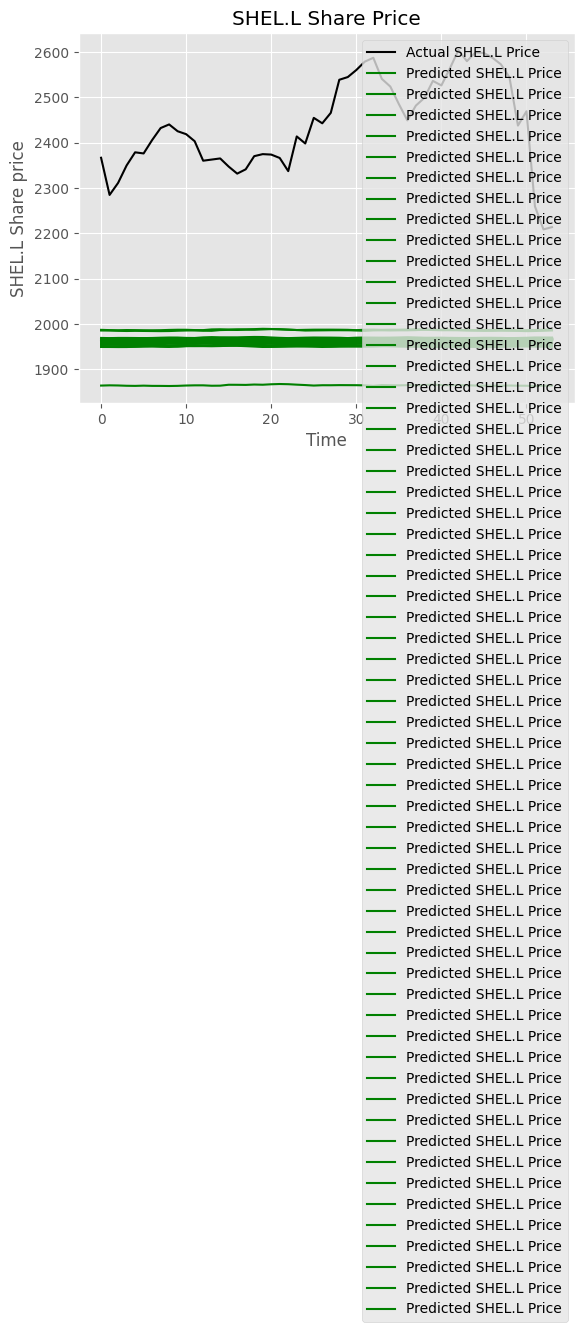

In [96]:
plt.plot(actual_prices, color='black', label=f'Actual {company} Price')
plt.plot(predicted_prices, color='green', label=f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share price')
plt.legend()
plt.show()